In [12]:
import pandas as pd
import os
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import numpy as np
import joblib
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline
import sys

sys.path.append('..')
from helpers.readers import read_dataframe

DATA_PATH = '../generated/annotations_2023/'

### How to get the data
1. Download from [here](https://drive.google.com/drive/folders/1pSyWy1uQqbTe4xCt9TtvIQM0YTyVZ8Tr?usp=drive_link) `tokens.parquet`, `dependencies.parquet` and `entities.parquet` (generated from [`Text to Dataframes (2023).ipnyb`](https://github.com/epfl-ada/ada-2023-project-crunchychicken/blob/main/pipelines/Text%20to%20Dataframes%20(2023).ipynb))
2. Place the files inside `annotations_2023/`:
```
project_root/
│
├── P2.ipynb
│
├── generated/
│   ├── annotations_2023/
```

In [2]:
tokens = read_dataframe('cmu/tokens_2023')
dependencies = read_dataframe('cmu/dependencies_2023')
entities = read_dataframe('cmu/entities_2023')
# coreference is complex to integrate, for now we will use these three dataframes

In [3]:
tokens['token_id'] = tokens.groupby(['Wikipedia_movie_id', 'Sentence_id']).cumcount() + 1 # adding token id, not present by default in 4.5.5
tokens = tokens.drop(['Sentiment', 'COB', 'COE'], axis=1) # can use Sentiment later

In [4]:
# 15M            15M                 2.2M
len(tokens), len(dependencies), len(entities)

(15046378, 15376339, 2220379)

### Preprocessing
Running on such big dataframes will take too much time. To solve this, we will first filter on movie plots that contain a character (from the entities dataframe check for `Entity_type == PERSON` and a non NaN `Optional_probability`) and on also filter on the dependencies (from the dependencies dataframe check that the `Dependency_type` satisfies an agent verb, patient verb or attribute).

In [5]:
%%time
agent_verbs = ["agent", "nsubj"]
patient_verbs = ["dobj", "nsubjpass", "iobj"] # no prep_ using coreNLP4.5.5
attributes_av = ["nsubj", "appos"]
attributes_pv = ["nsubj", "appos", "amod", "nn"]

def is_matching_dependency(dep_type):
    if dep_type in agent_verbs or dep_type in patient_verbs or dep_type in attributes_av or dep_type in attributes_pv:
        return True
    else: return False

tokens_with_character = tokens[tokens["NER"] == "PERSON"]["Wikipedia_movie_id"].tolist()
entities_with_character = entities[(entities['Entity_type'] == 'PERSON') & (entities['Optional_probability'].notna())]["Wikipedia_movie_id"].tolist()
prefiltered_entities = entities[(entities['Entity_type'] == 'PERSON') & (entities['Optional_probability'].notna())].copy()
dependencies_with_dep = dependencies[dependencies['Dependency_type'].apply(is_matching_dependency)]["Wikipedia_movie_id"].tolist()
prefiltered_dependencies = dependencies[dependencies['Dependency_type'].apply(is_matching_dependency)].copy()

set_tokens = set(tokens_with_character)
set_entities = set(entities_with_character)
set_dependencies = set(dependencies_with_dep)

intersection_set = set_tokens & set_entities & set_dependencies

filtered_tokens = tokens[tokens["Wikipedia_movie_id"].isin(intersection_set)]
filtered_entities = prefiltered_entities[prefiltered_entities["Wikipedia_movie_id"].isin(intersection_set)]
filtered_dependencies = prefiltered_dependencies[prefiltered_dependencies["Wikipedia_movie_id"].isin(intersection_set)]

CPU times: total: 19.4 s
Wall time: 20 s


In [6]:
len(filtered_tokens), len(filtered_dependencies), len(filtered_entities)

(14714763, 3603836, 848088)

In [7]:
%%time
word_to_character = {}
for _, row in filtered_entities.iterrows():
    character_name = row['Word']
    movie_id = row['Wikipedia_movie_id']
    sentence_id = row['Sentence_id']
    for word in character_name.split():
        key = (movie_id, sentence_id, word)
        word_to_character[key] = character_name

filtered_tokens_copy = filtered_tokens.copy()

def map_word_to_character(row):
    key = (row['Wikipedia_movie_id'], row['Sentence_id'], row['Word'])
    return word_to_character.get(key, '')

filtered_tokens_copy['Character'] = filtered_tokens_copy.apply(map_word_to_character, axis=1)

CPU times: total: 3min 22s
Wall time: 3min 25s


In [8]:
%%time
merge1 = pd.merge(filtered_tokens_copy, filtered_dependencies, left_on=['Wikipedia_movie_id', 'Sentence_id', 'token_id'], right_on=['Wikipedia_movie_id', 'Sentence_id', 'Word_1_idx'])

merge2 = pd.merge(filtered_tokens_copy, filtered_dependencies, left_on=['Wikipedia_movie_id', 'Sentence_id', 'token_id'], right_on=['Wikipedia_movie_id', 'Sentence_id', 'Word_2_idx'])

final_merged_df = pd.concat([merge1, merge2], ignore_index=True)

CPU times: total: 27.5 s
Wall time: 27.9 s


In [9]:
final_merged_df

,Wikipedia_movie_id,Sentence_id,Word,POS,Lemma,NER,token_id,Character,Dependency_type,Word_1,Word_1_idx,Word_2,Word_2_idx
0,11784534,1,Bergman,NNP,Bergman,PERSON,7,Ingrid Bergman,nn,Bergman,7,Ingrid,6
1,11784534,1,Sanders,NNP,Sanders,PERSON,10,George Sanders,nn,Sanders,10,George,9
2,11784534,1,couple,NN,couple,O,15,,nsubj,couple,15,Joyces,2
3,11784534,1,couple,NN,couple,O,15,,amod,couple,15,English,14
4,11784534,1,gone,VBN,go,O,18,,nsubj,gone,18,who,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207667,9990262,48,min,NNP,min,O,10,,nsubj,asks,12,min,10
7207668,9990262,48,min,NNP,min,O,10,,nsubj,get,14,min,10
7207669,9990262,48,head,NN,head,O,16,,nn,surgery,22,head,16
7207670,9990262,48,toe,NN,toe,O,20,,nn,plastic,21,toe,20


In [10]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%load_ext memory_profiler
%memit
import gc

del filtered_entities
del filtered_tokens_copy
del filtered_dependencies
del filtered_tokens
del dependencies
del dependencies_with_dep
del entities
del entities_with_character
del intersection_set
del merge1
del merge2 
del prefiltered_dependencies
del prefiltered_entities
del set_dependencies        
del set_entities              
del set_tokens
del tokens
del tokens_with_character

gc.collect()
%memit

peak memory: 10949.94 MiB, increment: 0.04 MiB
peak memory: 6863.02 MiB, increment: 0.00 MiB


### Adding the POS and lemma of dependencies to the merged dataframe before running extractor

In [ ]:
def get_dependency_pos_lemma(row):
    if row['Character']:
        dependency_idx = row['Word_2_idx'] if row['Word'] == row['Word_1'] else row['Word_1_idx']

        pos_lemma = final_merged_df.loc[(final_merged_df['Wikipedia_movie_id'] == row['Wikipedia_movie_id']) &
                                        (final_merged_df['Sentence_id'] == row['Sentence_id']) &
                                        (final_merged_df['token_id'] == dependency_idx), ['POS', 'Lemma']].iloc[0]
        return pos_lemma.POS, pos_lemma.Lemma
    return '', ''

Will take around 2 hours 👇

In [ ]:
%%time
def process_chunk(chunk):
    return chunk.apply(get_dependency_pos_lemma, axis=1)

num_partitions = joblib.cpu_count()
chunk_size = int(np.ceil(final_merged_df.shape[0] / num_partitions))
chunks = [final_merged_df.iloc[i:i + chunk_size] for i in range(0, final_merged_df.shape[0], chunk_size)]

results = Parallel(n_jobs=num_partitions)(delayed(process_chunk)(chunk) for chunk in chunks)

pos_lemma_df = pd.concat(results, ignore_index=True)

final_merged_df = pd.concat([final_merged_df.reset_index(drop=True), pos_lemma_df], axis=1)

final_merged_df_filtered = final_merged_df[final_merged_df['Character'] != '']

In [ ]:
final_merged_df_filtered = final_merged_df_filtered.copy()

final_merged_df_filtered.loc[:, 'Dependency_POS'] = final_merged_df_filtered[0].apply(lambda x: x[0])
final_merged_df_filtered.loc[:, 'Dependency_Lemma'] = final_merged_df_filtered[0].apply(lambda x: x[1])

final_merged_df_filtered = final_merged_df_filtered.drop(columns=[0])

final_merged_df_filtered

In [ ]:
del results
del pos_lemma_df
del final_merged_df
gc.collect()

In [ ]:
final_merged_df_filtered

### Extractor

In [ ]:
characters = pd.DataFrame(columns=['Wikipedia_movie_id', 'Character', 'AV', 'PV', 'Att']) # dataframe where we will store the character, its actions (agent and patient) and attributes
verb_pos_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"] # to indentify verbs from attributes

In [ ]:
%%time
def process_chunk(chunk):
    temp_data = defaultdict(lambda: {'AV': [], 'PV': [], 'Att': []})
    for _, row in chunk.iterrows():
        result = process_row(row)
        key = (result['Wikipedia_movie_id'], result['Character'])
        temp_data[key]['AV'].extend(result['AV'])
        temp_data[key]['PV'].extend(result['PV'])
        temp_data[key]['Att'].extend(result['Att'])
    return temp_data

num_partitions = joblib.cpu_count()
chunk_size = int(np.ceil(final_merged_df_filtered.shape[0] / num_partitions))
chunks = [final_merged_df_filtered.iloc[i:i + chunk_size] for i in range(0, final_merged_df_filtered.shape[0], chunk_size)]

chunk_results = Parallel(n_jobs=num_partitions)(delayed(process_chunk)(chunk) for chunk in chunks)

combined_results = defaultdict(lambda: {'AV': [], 'PV': [], 'Att': []})
for chunk_result in chunk_results:
    for key, values in chunk_result.items():
        combined_results[key]['AV'].extend(values['AV'])
        combined_results[key]['PV'].extend(values['PV'])
        combined_results[key]['Att'].extend(values['Att'])

character_data = []
for (movie_id, character), values in combined_results.items():
    character_data.append({
        'Wikipedia_movie_id': movie_id,
        'Character': character,
        'AV': values['AV'],
        'PV': values['PV'],
        'Att': values['Att']
    })

characters = pd.DataFrame(character_data)

In [ ]:
characters.to_parquet(os.path.join(DATA_PATH, "characters.parquet"), compression= "brotli")

In [ ]:
characters

### Generate bag of words
A bag is a tupple of $(r,w)$, where $r$ is of {agent verb, patient verb, attribute} and $w$ is the lemma of the word.

In [ ]:
def generate_bags_of_words(characters_df: pd.DataFrame):
    bags_of_words = []

    for _, row in tqdm(characters_df.iterrows()):
        movie_id = row['Wikipedia_movie_id']
        character_name = row['Character']

        av = row['AV'] if isinstance(row['AV'], list) else []
        pv = row['PV'] if isinstance(row['PV'], list) else []
        att = row['Att'] if isinstance(row['Att'], list) else []

        for verb in av:
            bags_of_words.append((movie_id, character_name, 'agent_verb', verb))

        for verb in pv:
            bags_of_words.append((movie_id, character_name, 'patient_verb', verb))

        for attribute in att:
            bags_of_words.append((movie_id, character_name, 'attribute', attribute))

    return bags_of_words

bags_of_words = generate_bags_of_words(characters)

In [ ]:
bags_df = pd.DataFrame(bags_of_words, columns=['movie_id', 'character_name', 'type', 'word'])
bags_df.to_parquet(os.path.join(DATA_PATH, "bags.parquet"), compression= "brotli")

### From tupples to topics using LDA

In [2]:
bags_df = read_dataframe('cmu/bags_2023')
bags_of_words=bags_df.values

bags_df.head(3)

,movie_id,character_name,type,word
0,11784534,Ingrid Bergman,attribute,Ingrid
1,11784534,Ingrid Bergman,attribute,Bergman
2,11784534,George Sanders,attribute,George


In [5]:
# currently global character version (doesn't make the distinction of the same character in different movies)
character_docs = defaultdict(list)
for _, character, _, word in bags_of_words:
    character_docs[character].append(word)
    
for character in character_docs:
    character_docs[character] = " ".join(character_docs[character])
    
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(character_docs.values())

n_topics = 50
lda = LatentDirichletAllocation(n_components=n_topics, verbose=2, max_iter=10, random_state = 0)
lda.fit(X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s finished


LatentDirichletAllocation(n_components=50, random_state=0, verbose=2)

In [6]:
joblib.dump(lda, os.path.join(DATA_PATH, "lda_model.gz"), compress=('gzip', 9))

['../generated/annotations_2023/lda_model.gz']

In [7]:
lda = joblib.load(os.path.join(DATA_PATH, "lda_model.gz"))

In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_topic_words = 10
print_top_words(lda, vectorizer.get_feature_names_out(), n_topic_words)

Topic 0: jack li le nair hung law feature man fei chakraborty
Topic 1: story dean lane photographer phillips hank perry keith wade hand
Topic 2: van brown helsing worker betty gangster co laura call fang
Topic 3: show shoot confront appear agent order family face senator colonel
Topic 4: nick edward howard writer lewis parker pete lin philip robinson
Topic 5: marry sheriff prasad fred babu big blackmail dealer veteran lo
Topic 6: de colonel lieutenant partner producer wu ed roberts sally murphy
Topic 7: john charles danny st ross defeat norman aunt neil amy
Topic 8: brother ben ho bhai louis helen allen ravi soo eun
Topic 9: businessman maria ram anna wang feng nurse emperor pierre arnold
Topic 10: george jean woo jason russell stanley hyun thompson nicholas ian
Topic 11: miss kumar max jerry secretary roger elizabeth ryan tim graham
Topic 12: jim boy taylor larry morgan brian dick jonathan wayne shankar
Topic 13: william jr dan davis albert blake walker joan rachel bennett
Topic 14: t

In [9]:
character_topic = lda.transform(X)
character_names = list(character_docs.keys())

character_classification=[]

for i, topic_dist in enumerate(character_topic):
    topic_most_prob = topic_dist.argmax()
    character_classification.append((character_names[i], topic_most_prob, topic_dist))

character_classification_df=pd.DataFrame(character_classification,columns=['character_name', 'topic', 'topic_dist'])
character_classification_df.head(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


,character_name,topic,topic_dist
0,Ingrid Bergman,23,"[0.0010526315789476945, 0.0010526315789476945,..."
1,George Sanders,10,"[0.002000000000000205, 0.002000000000000205, 0..."
2,Wile E. Coyote,23,"[0.00010526315789478957, 0.0001052631578947895..."


In [10]:
character_classification_df.to_parquet(os.path.join(DATA_PATH, "character_classification.parquet"), compression= "brotli")

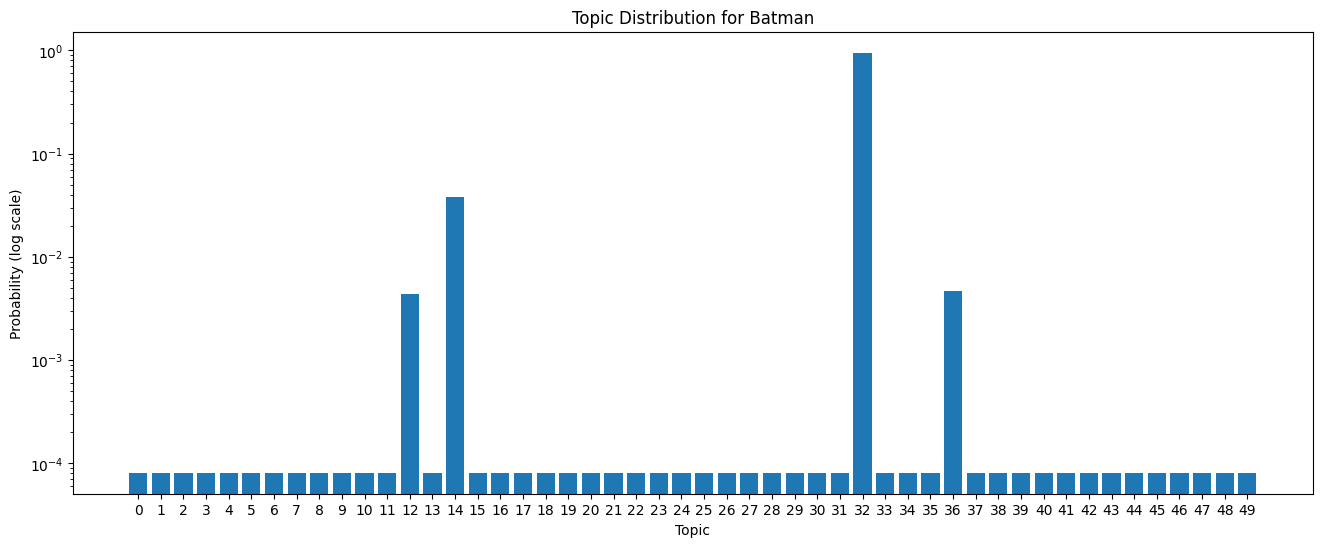

In [13]:
character='Batman'

character_topics = character_classification_df[character_classification_df['character_name'] == character]['topic_dist'].iloc[0]

topics = range(len(character_topics))

# Creating the plot
plt.figure(figsize=(16, 6))
plt.bar(topics, character_topics)
plt.xlabel('Topic')
plt.ylabel('Probability (log scale)')
plt.title(f'Topic Distribution for {character}')
plt.yscale('log')  
plt.xticks(topics)
plt.show()

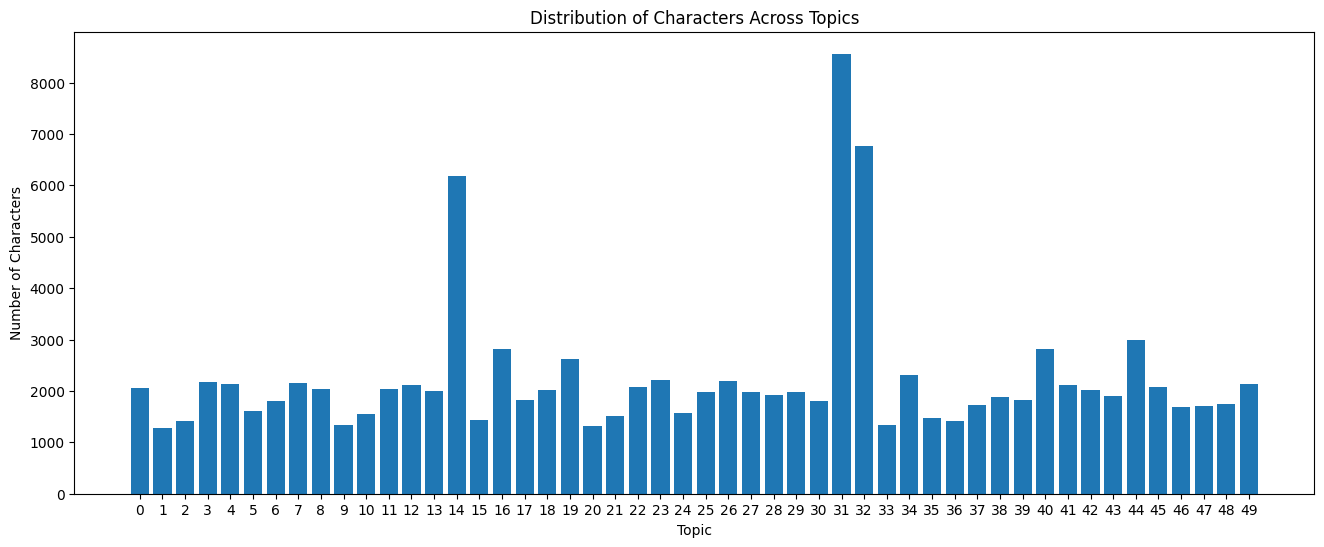

In [14]:
topic_counts = character_classification_df['topic'].value_counts()

topic_counts = topic_counts.sort_index()

plt.figure(figsize=(16, 6))
plt.bar(topic_counts.index, topic_counts.values)

plt.xlabel('Topic')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters Across Topics')
plt.xticks(topic_counts.index)
plt.show()